In [373]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.optimize import curve_fit

import emcee
import corner

import uncertainties as un
import uncertainties.unumpy as unp
from uncertainties.unumpy import nominal_values, std_devs
err = std_devs
nom = nominal_values

from li_funks.plot import savefig

In [390]:
df = pd.read_pickle('data/processed_LiDataFull.pkl')  # use pickle to preserve uncertainty info
sdf = pd.read_pickle('data/processed_LiDataSummary.pkl')  # use pickle to preserve uncertainty info

lit = pd.read_pickle('data/processed_LiDataLiterature.pkl')
inorg = lit.loc['calcite']
fug = inorg.loc['Fuger2019']

In [463]:
rdict = {
    'Fuger2019': 'Fuger et al. (2019, 2022)',
    'This Study': 'This Study',
}

mdict = {
    'Fuger2019': 's',
    'This Study': 'o',
}

In [462]:
# compile data

database = 'pitzer'

# Independent Variables
Rp = np.concatenate([nom(df.R.R_13C), nom(10**fug.solid.logR)])
Rp_err = err(df.R.R_13C)
Rp_err = np.concatenate([Rp_err, np.full(Rp.size - Rp_err.size, Rp_err.mean() * 2)])

mu = np.concatenate([df[database, 'mu'].values, fug[database, 'mu'].values])
temp = np.concatenate([df[database, 'temp(C)'].values, fug[database, 'temp(C)'].values])

la_OH = np.concatenate([df[database, 'la_OH-'].values, fug[database, 'la_OH-'].values])
OH = 10**la_OH
la_HCO3 = np.concatenate([df[database, 'la_HCO3-'].values, fug[database, 'la_HCO3-'].values])
HCO3 = 10**la_HCO3
la_Li = np.concatenate([df[database, 'la_Li+'].values, fug[database, 'la_Li+'].values])
m_Li = np.concatenate([df[database, 'm_Li+(mol/kgw)'].values, fug[database, 'm_Li+(mol/kgw)'].values])

Li_activity_ratio = 10**la_Li / m_Li

study = np.concatenate([np.full(df.shape[0], 'This Study'), np.full(fug.shape[0], 'Fuger2019')])

# Li Partitioning
DLi = np.concatenate([nom(df.OG.DLi), nom(fug.solid.DLi)])
DLi_err = np.concatenate([err(df.OG.DLi), fug.solid.DLi_2std / 2])
uDLi = unp.uarray(DLi, DLi_err)

sol_Li = np.concatenate([df.solution.Li, fug.solution.Li])
sol_Ca = np.concatenate([df.solution.Ca, fug.solution.Ca])
sol_LiCa = sol_Li / sol_Ca
usolid_LiCa = uDLi * sol_LiCa
solid_LiCa = nom(usolid_LiCa)
solid_LiCa_err = err(usolid_LiCa)

e7Li = np.concatenate([nom(df.Li_isotopes_vs_fluid.epsilon_og), nom(fug.solid.epsilon_7Li)])
e7Li_err = np.concatenate([err(df.Li_isotopes_vs_fluid.epsilon_og), fug.solid.epsilon_7Li_2std / 2])

e7Li_err = e7Li_err[~np.isnan(e7Li)]
e7Li = e7Li[~np.isnan(e7Li)]


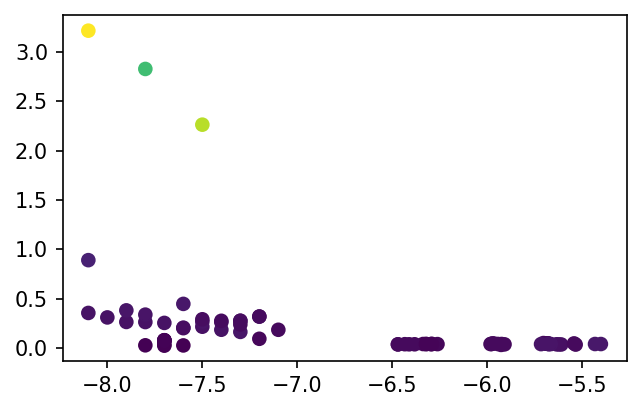

In [392]:
plt.scatter(np.log10(Rp), sol_LiCa, c=OH)

## Standard SKM

In [393]:
def SKM(Rp, Kf, Keq, Rb=6e-7):
    """
    DePaolo's (2011) Surface Kinetic Model
    
    Parameters
    ----------
    Kf : array-like
        The kinetic ('forward') fractionation factor.
        Kp will asymptote towards this value at high
        Rp.
    Keq : array-like
        The equilibrium fractionation factor. Kp will
        asymptote towards this values at low Rp.
    Rp : array-like
        Precipitation rate.
    Rb : array-like
        Ion detachment rate.

    Returns
    -------
    Kp : array-like
        Partitioning / fractionation of element in precipitated mineral.
    """
    return Kf / (1 + Rb * (Kf / Keq - 1) / (Rp + Rb))

def log_prior(theta):
    Kf, Keq, logRb = theta
    if np.any(Kf < 0) or np.any(Keq < 0):
        return -np.inf

    return np.sum(stats.truncnorm.logpdf(logRb, loc=-7, scale=1, a=-3, b=2))
    
def log_likelihood(theta, Rp, DLi, Rp_err, DLi_err):
    Kf, Keq, logRb = theta
    model = SKM(Rp, Kf, Keq, 10**logRb)
    sigma2 = DLi_err**2 + Rp_err**2
    return -0.5 * np.sum((DLi - model)**2 / sigma2 + np.log(sigma2))

def log_probability(theta, Rp, DLi, Rp_err, DLi_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Rp, DLi, Rp_err, DLi_err)

(array([ 8.,  1., 47.,  1.,  6.,  7.,  0.,  0.,  0.,  4.]),
 array([-3.0764799 , -2.94713468, -2.81778946, -2.68844424, -2.55909902,
        -2.42975379, -2.30040857, -2.17106335, -2.04171813, -1.91237291,
        -1.78302768]),
 <BarContainer object of 10 artists>)

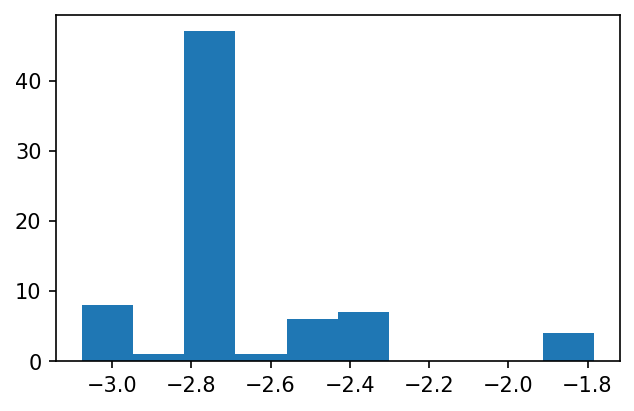

In [435]:
plt.hist(la_HCO3)

In [446]:
initial = 0.0014, 1e-5, -7

nwalkers = 32
ndim = len(initial)

start = initial + 1e-7 * np.random.randn(nwalkers, len(initial))

ind = np.isclose(la_HCO3, -2.8, atol=0.2)
print(ind.sum())
# ind = np.isclose(la_OH, -6, atol=0.3)
# ind = np.ones(Rp.shape, dtype=bool)
inputs = (Rp[ind], DLi[ind], Rp_err[ind], DLi_err[ind])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=inputs)
sampler.run_mcmc(start, 5000, progress=True);


50


100%|██████████| 5000/5000 [00:20<00:00, 240.01it/s]


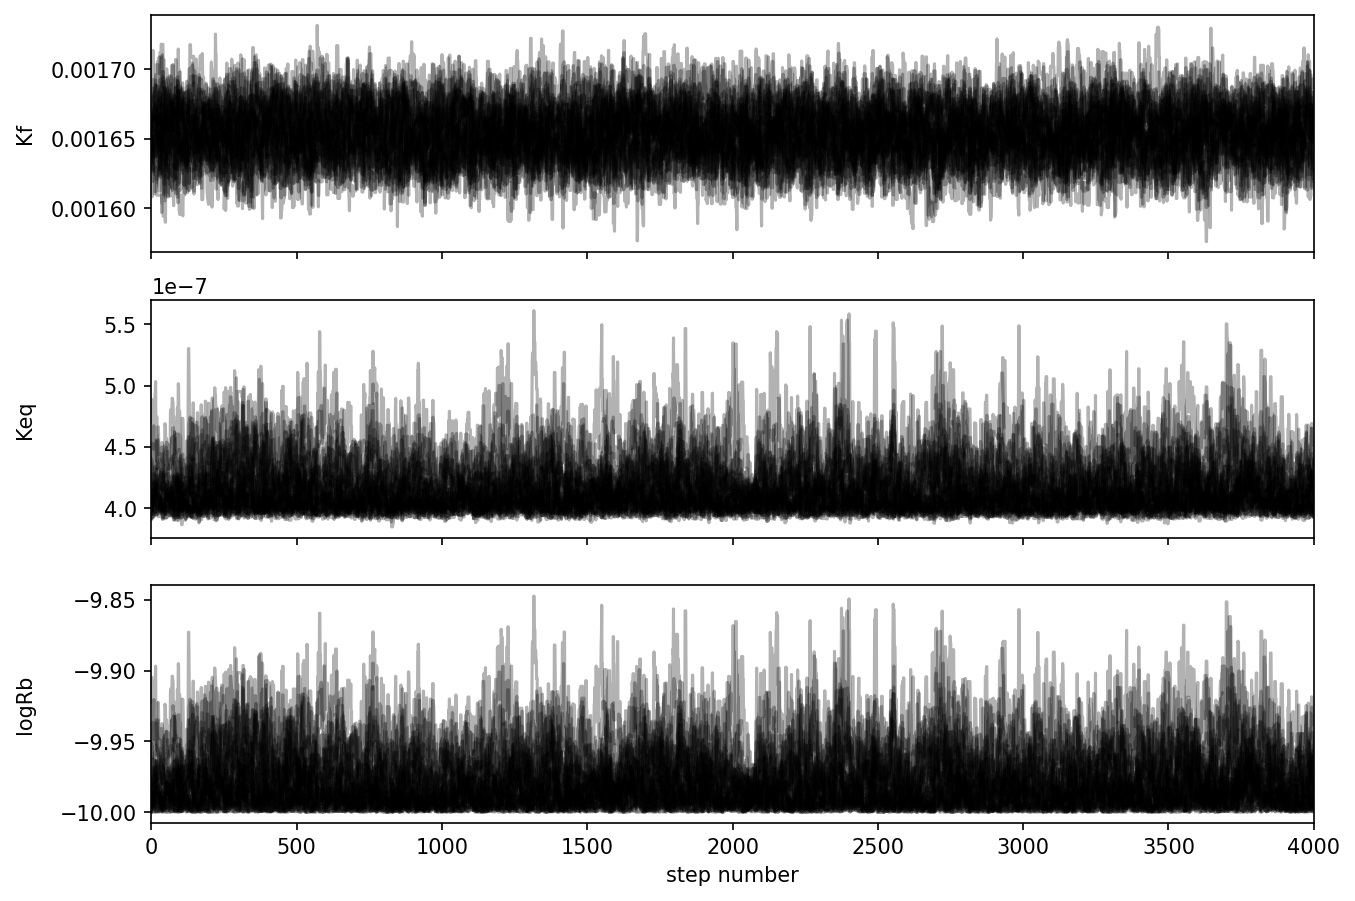

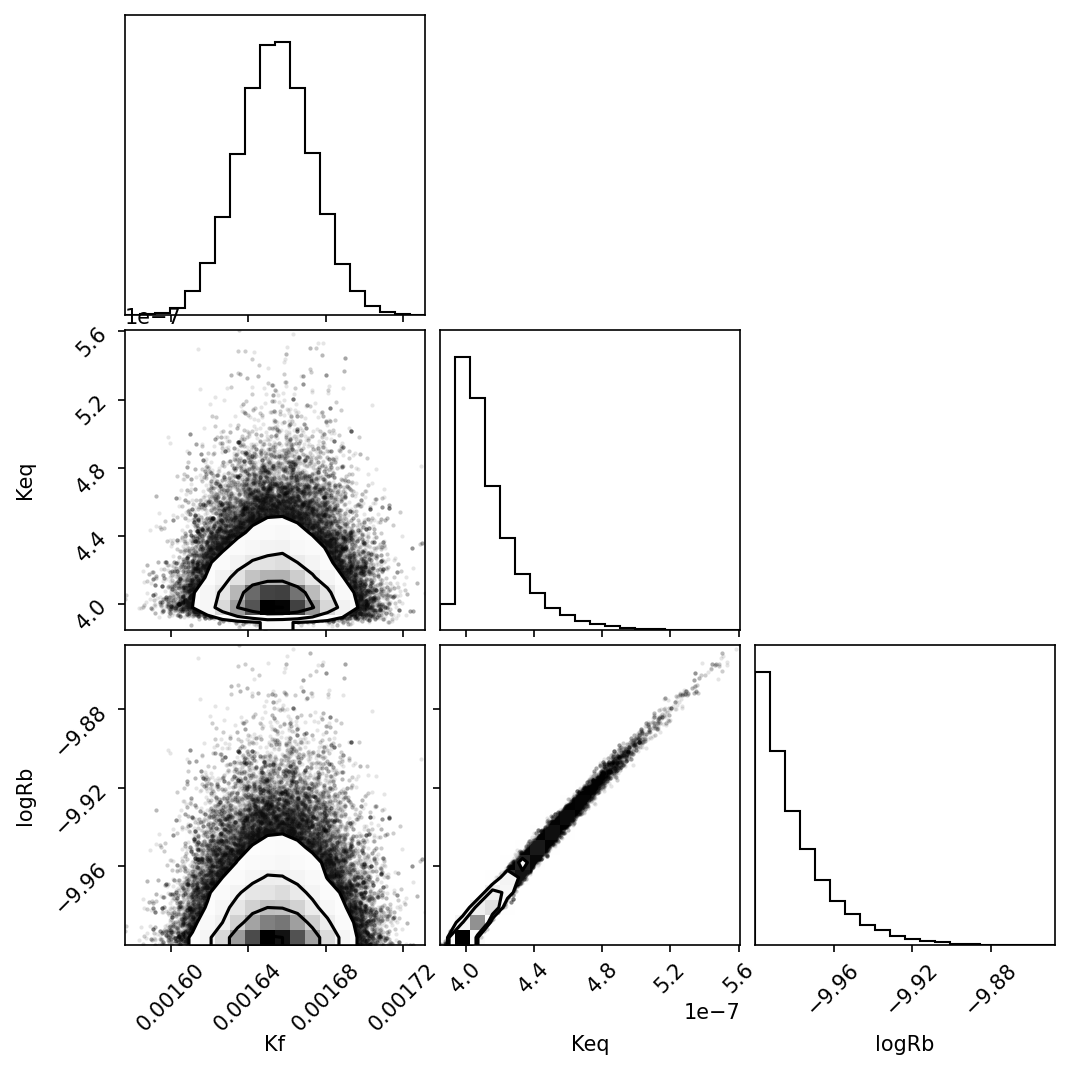

In [447]:
burnin=1000
samples = sampler.get_chain(discard=burnin)
flat_samples = sampler.get_chain(discard=burnin, flat=True)
labels = 'Kf', 'Keq', 'logRb'

fig, axs = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axs[-1].set_xlabel("step number");

corner.corner(flat_samples, labels=labels);

In [448]:
nRp = np.logspace(-8.5, -5, 100)
pred = SKM(nRp.reshape(-1,1), flat_samples[:,0], flat_samples[:,1], 10**flat_samples[:,2])

CI = 0.95
plo, pmid, phi = np.quantile(pred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

In [449]:
# plt.scatter(la_OH, la_HCO3)

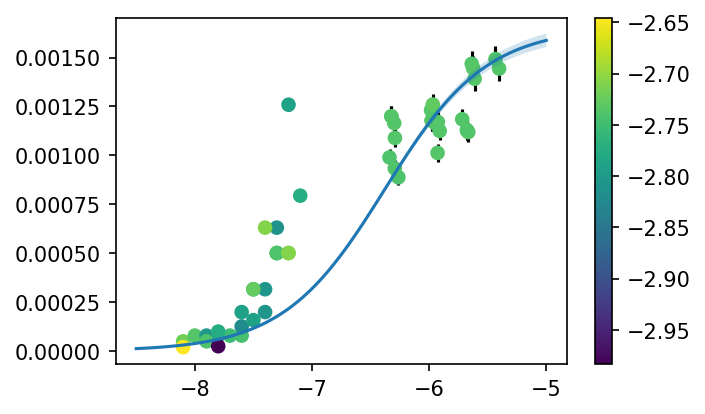

In [450]:
# laOH invariant
# ind = np.isclose(la_OH, -6, atol=0.5)

plt.errorbar(np.log10(Rp[ind]), DLi[ind], yerr=DLi_err[ind], fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp[ind]), DLi[ind], c=la_HCO3[ind])

plt.plot(np.log10(nRp), pmid)
plt.fill_between(np.log10(nRp), plo, phi, alpha=0.2)

plt.colorbar()


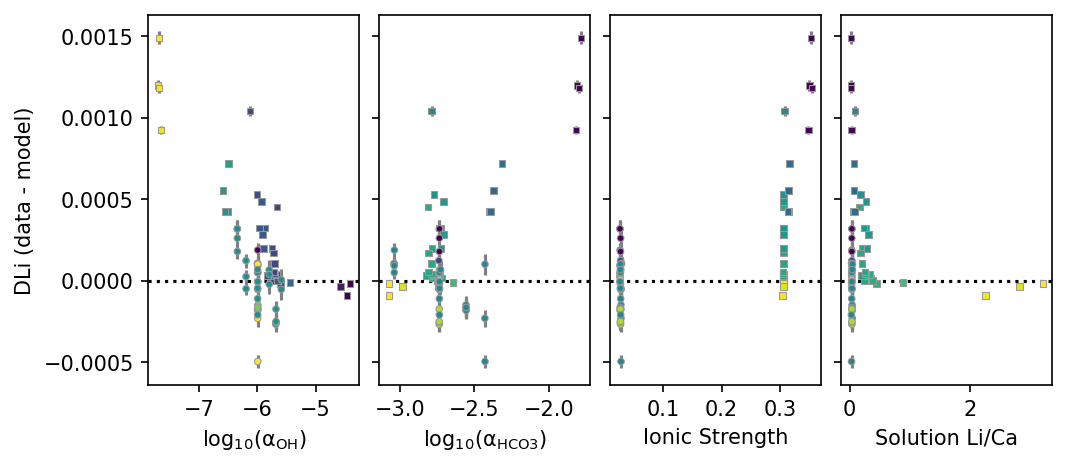

In [472]:
dpred = SKM(Rp.reshape(-1,1), flat_samples[:,0], flat_samples[:,1], 10**flat_samples[:,-1])

dplo, dpmid, dphi = np.quantile(dpred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

resid = DLi - dpmid

fig, axs = plt.subplots(1, 4, figsize=[7, 3], sharey=True, constrained_layout=True)

for s in np.unique(study):
    ind = study == s

    axs[0].scatter(la_OH[ind], resid[ind], s=10, c=la_HCO3[ind], marker=mdict[s], lw=0.5, edgecolor=(.6,.6,.6))
    axs[0].errorbar(la_OH[ind], resid[ind], yerr=DLi_err[ind], fmt='none', c='grey', zorder=-3)

    axs[1].scatter(la_HCO3[ind], resid[ind], s=10, c=la_OH[ind], marker=mdict[s], lw=0.5, edgecolor=(.6,.6,.6))
    axs[1].errorbar(la_HCO3[ind], resid[ind], yerr=DLi_err[ind], fmt='none', c='grey', zorder=-3)

    axs[2].scatter(mu[ind], resid[ind], s=10, c=la_OH[ind], marker=mdict[s], lw=0.5, edgecolor=(.6,.6,.6))
    axs[2].errorbar(mu[ind], resid[ind], yerr=DLi_err[ind], fmt='none', c='grey', zorder=-3)

    axs[3].scatter(sol_LiCa[ind], resid[ind], s=10, c=la_OH[ind], marker=mdict[s], lw=0.5, edgecolor=(.6,.6,.6))
    axs[3].errorbar(sol_LiCa[ind], resid[ind], yerr=DLi_err[ind], fmt='none', c='grey', zorder=-3)

axs[0].set_ylabel('DLi (data - model)')

axs[0].set_xlabel('$log_{10}(\\alpha_{OH})$')
axs[1].set_xlabel('$log_{10}(\\alpha_{HCO3})$')
axs[2].set_xlabel('Ionic Strength')
axs[3].set_xlabel('Solution Li/Ca')

for ax in axs:
    ax.axhline(0, ls=':', c='k', zorder=-1)

In [427]:
mu

array([0.02763646, 0.02544845, 0.02648383, 0.02670458, 0.0258291 ,
       0.02633102, 0.02665337, 0.02603623, 0.0281575 , 0.0281575 ,
       0.02571531, 0.02561259, 0.02538987, 0.02719997, 0.02710938,
       0.02664209, 0.02581679, 0.02581679, 0.02727252, 0.02724623,
       0.02620623, 0.02650718, 0.02605638, 0.02633766, 0.02633766,
       0.02645401, 0.02666841, 0.02553976, 0.02553976, 0.02701579,
       0.02678209, 0.02672684, 0.02612654, 0.0263327 , 0.02626095,
       0.02571227, 0.02571227, 0.30628847, 0.30656733, 0.30738338,
       0.30596378, 0.30624671, 0.30601136, 0.30559955, 0.30675838,
       0.30571683, 0.30590149, 0.30614833, 0.30585178, 0.30582235,
       0.30579203, 0.30632894, 0.30614008, 0.3064514 , 0.30684389,
       0.3067091 , 0.3067091 , 0.30632464, 0.30616309, 0.30616309,
       0.30845284, 0.30660729, 0.30638458, 0.30632459, 0.30519018,
       0.35058665, 0.34885517, 0.35518335, 0.35387846, 0.31493228,
       0.31493228, 0.31472304, 0.31652872, 0.31439455])

## Li pairing modifies solution Li/Ca

In [379]:
def log_prior(theta):
    Kf, Keq, logRb, *_ = theta
    if np.any(Kf < 0) or np.any(Keq < 0):
        return -np.inf
    return np.sum(stats.truncnorm.logpdf(logRb, loc=-7, scale=1, a=-3, b=2))

def log_likelihood(theta, Rp, DLi, Rp_err, DLi_err):
    Kf, Keq, logRb = theta
    model = SKM(Rp, Kf, Keq, 10**logRb)
    sigma2 = DLi_err**2 + Rp_err**2
    return -0.5 * np.sum((DLi - model)**2 / sigma2 + np.log(sigma2))

def log_probability(theta, Rp, DLi, Rp_err, DLi_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Rp, DLi, Rp_err, DLi_err)

Text(0.5, 0, 'logR')

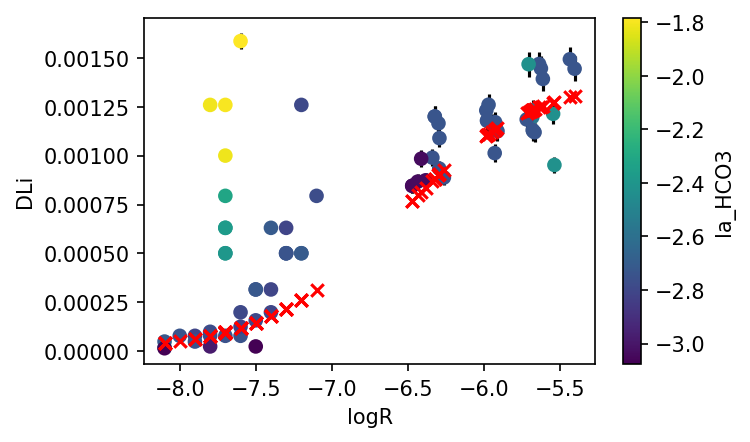

In [388]:
plt.errorbar(np.log10(Rp), DLi, yerr=DLi_err, fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp), DLi, c=la_HCO3)
plt.colorbar(label='la_HCO3')

SKM_D = SKM(Rp, 0.0014, 5e-6, 1e-9)
resid = DLi - SKM_D

pred_LiCa = SKM_D * sol_LiCa

mod_sol_LiCa = sol_LiCa + sol_Li * HCO3 / sol_Ca

pred_D = pred_LiCa / mod_sol_LiCa

plt.scatter(np.log10(Rp), pred_D, marker='x', color='r')

plt.ylabel('DLi')
plt.xlabel('logR')

In [187]:
modX = 10**la_OH
modX -= modX.mean()
modX /= modX.std()

initial = 0.0014, 1e-5, -7, 0

nwalkers = 32
ndim = len(initial)

start = initial + 1e-7 * np.random.randn(nwalkers, len(initial))

# ind = np.isclose(la_OH, -6, atol=0.5)
ind = np.ones(Rp.shape, dtype=bool)
inputs = (Rp[ind], modX[ind], DLi[ind], Rp_err[ind], DLi_err[ind])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_modD, args=inputs)
sampler.run_mcmc(start, 5000, progress=True);

100%|██████████| 5000/5000 [00:21<00:00, 234.38it/s]


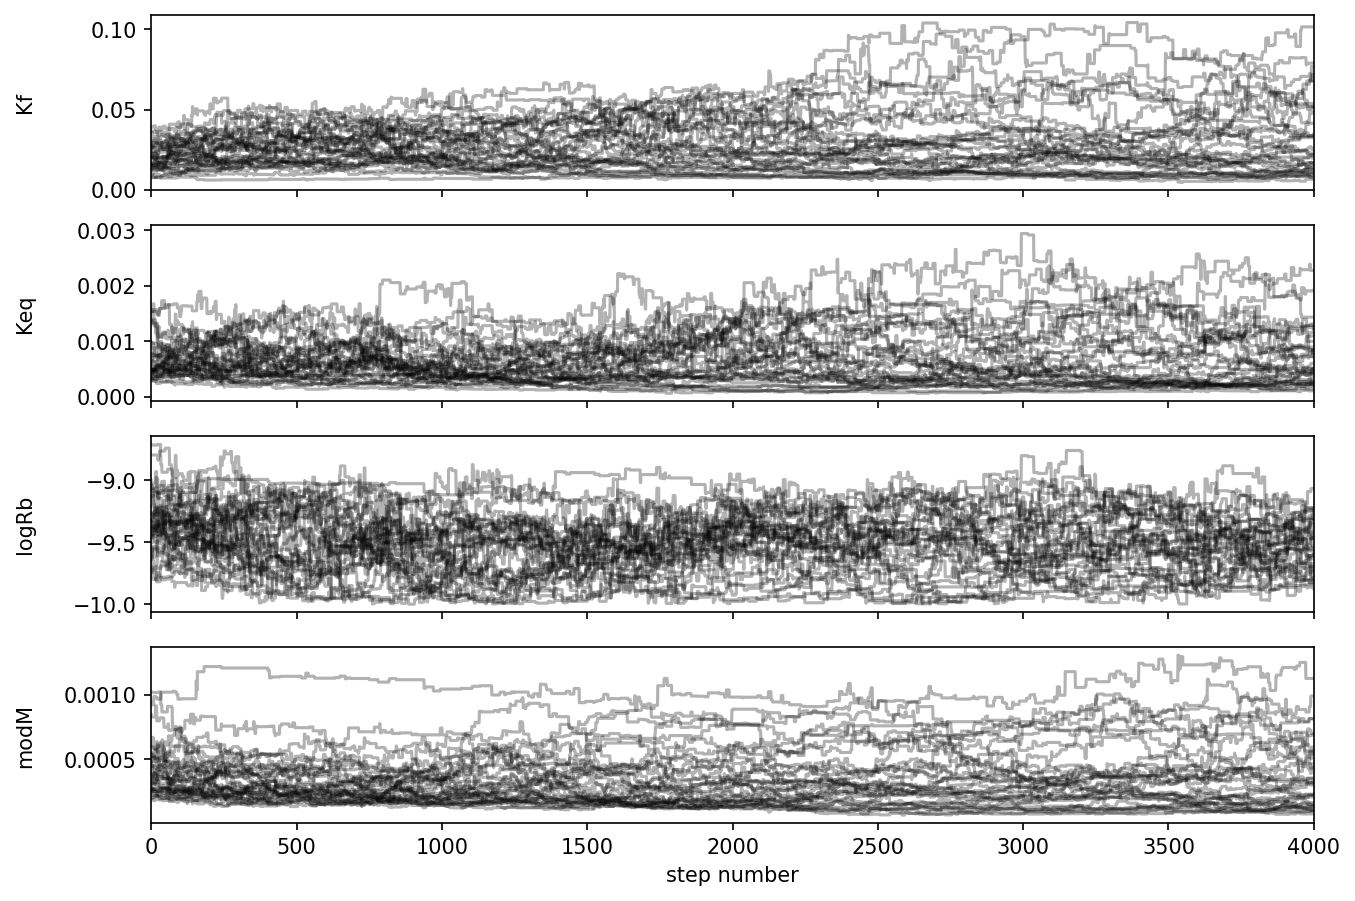

In [189]:
burnin=1000
samples = sampler.get_chain(discard=burnin)
flat_samples = sampler.get_chain(discard=burnin, flat=True)
labels = 'Kf', 'Keq', 'logRb', 'modM'

fig, axs = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axs[-1].set_xlabel("step number");

In [193]:
dpred = SKM_modD(Rp.reshape(-1,1), flat_samples[:,0], flat_samples[:, 1], flat_samples[:,-2], 10**flat_samples[:,-1])

dplo, dpmid, dphi = np.quantile(dpred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

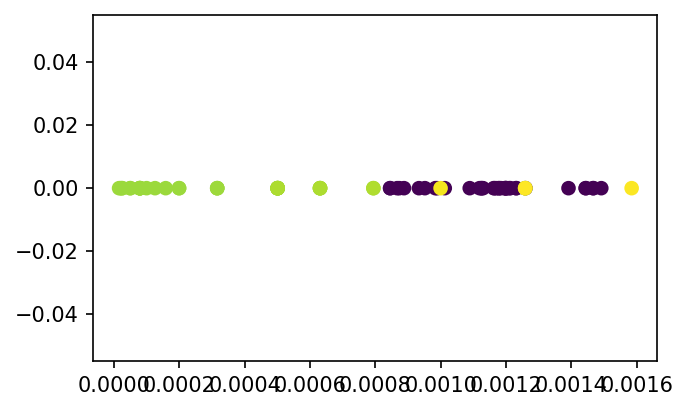

In [194]:
plt.scatter(DLi, dpmid, c=Kfx1)

## Variable Kf

In [337]:
def calc_Kvar1(Kx1, theta):
    K0, Km1 = theta
    return K0 + Kx1 * Km1

def calc_Kvar2(Kx1, Kx2, theta):
    K0, Km1, Km2 = theta
    return K0 + Kx1 * Km1 + Kx2 * Km2

def log_probability_Kfvar1(theta, Rp, Kfx1, DLi, Rp_err, DLi_err):
    *_, Keq, logRb = theta
    Kf = calc_Kvar1(Kfx1, theta[:2])
    
    lp = log_prior((Kf, Keq, logRb))
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood((Kf, Keq, logRb), Rp, DLi, Rp_err, DLi_err)

def log_probability_Kfvar2(theta, Rp, Kfx1, Kfx2, DLi, Rp_err, DLi_err):
    *_, Keq, logRb = theta
    Kf = calc_Kvar2(Kfx1, Kfx2, theta[:3])
    
    lp = log_prior((Kf, Keq, logRb))
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood((Kf, Keq, logRb), Rp, DLi, Rp_err, DLi_err)


SyntaxError: invalid syntax (1401789641.py, line 27)

In [353]:
Kfx1 = mu
Kfx1 -= Kfx1.mean()
Kfx1 /= Kfx1.std()

Kfx2 = la_HCO3
Kfx2 -= Kfx2.mean()
Kfx2 /= Kfx2.std()

initial = 0.0014, 0, 0, 1e-5, -8

nwalkers = 32
ndim = len(initial)

start = initial + 1e-7 * np.random.randn(nwalkers, len(initial))

# ind = np.isclose(la_OH, -6, atol=0.5)
ind = np.ones(Rp.shape, dtype=bool)
inputs = (Rp[ind], Kfx1[ind], Kfx2[ind], DLi[ind], Rp_err[ind], DLi_err[ind])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_Kfvar2, args=inputs)
sampler.run_mcmc(start, 5000, progress=True);


100%|██████████| 5000/5000 [00:23<00:00, 211.61it/s]


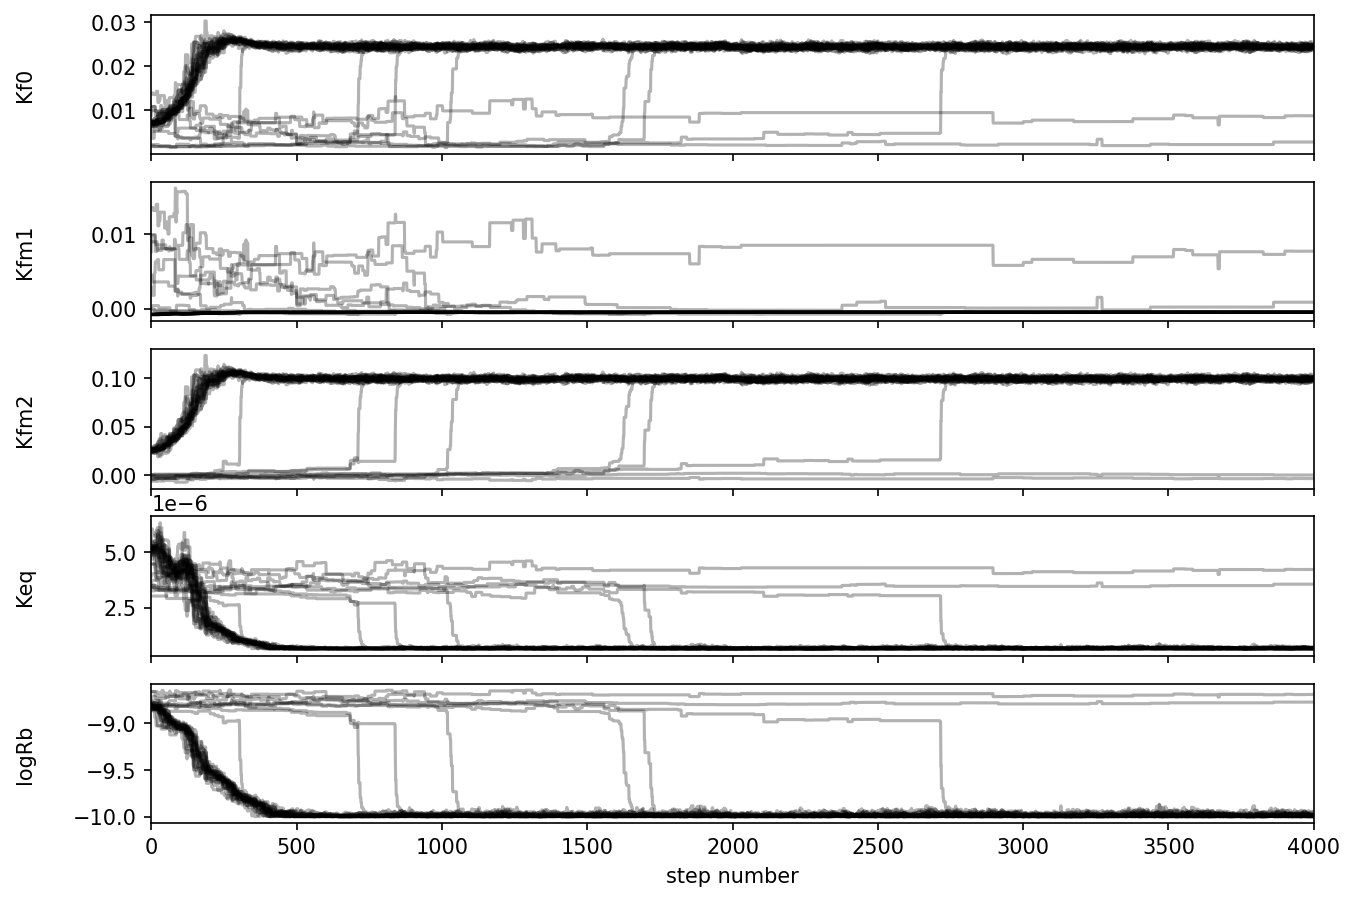

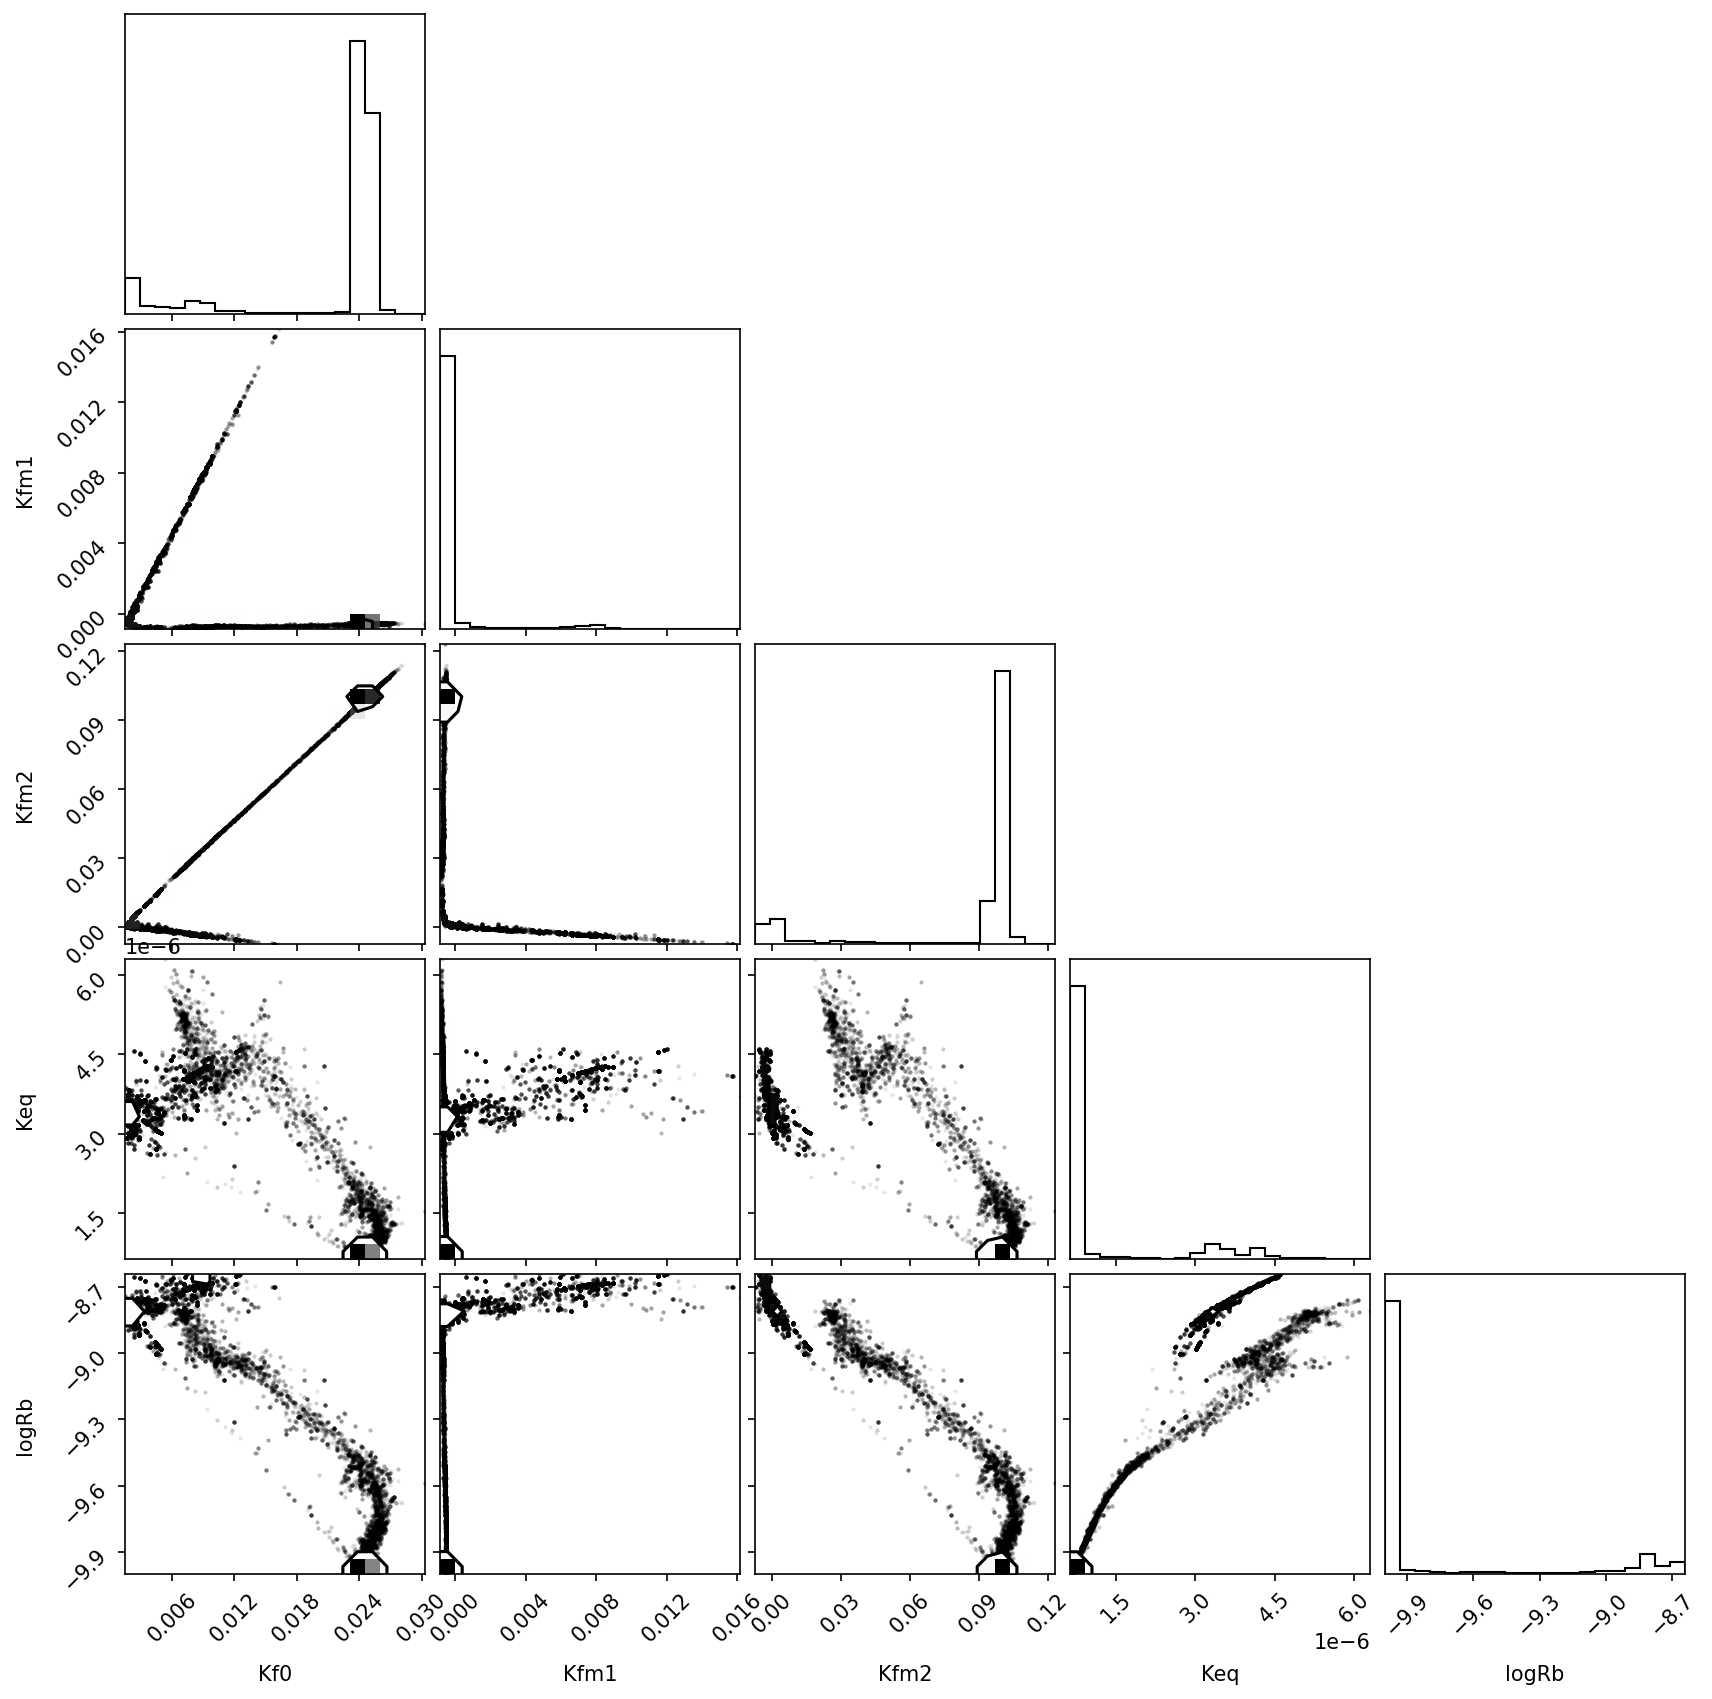

In [348]:
burnin=1000
samples = sampler.get_chain(discard=burnin)
flat_samples = sampler.get_chain(discard=burnin, flat=True)
labels = 'Kf0', 'Kfm1', 'Kfm2', 'Keq', 'logRb'

fig, axs = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axs[-1].set_xlabel("step number");

corner.corner(flat_samples, labels=labels);

In [349]:
nRp = np.logspace(-8.5, -5, 100)

pred = SKM(nRp.reshape(-1,1), flat_samples[:,0], flat_samples[:,-2], 10**flat_samples[:,-1])

CI = 0.95
plo, pmid, phi = np.quantile(pred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

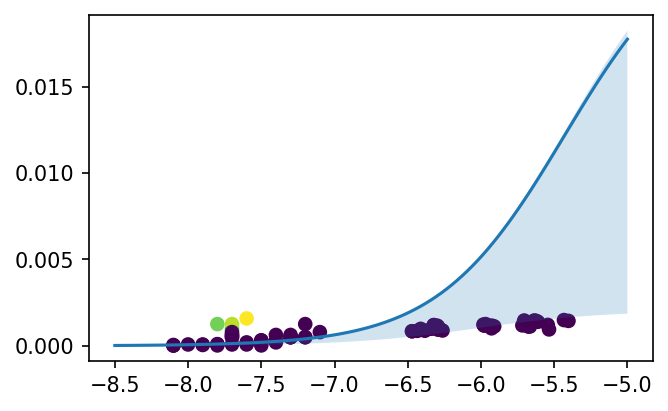

In [350]:
plt.errorbar(np.log10(Rp[ind]), DLi[ind], yerr=DLi_err[ind], fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp[ind]), DLi[ind], c=Kfx2[ind])

plt.plot(np.log10(nRp), pmid)
plt.fill_between(np.log10(nRp), plo, phi, alpha=0.2)

In [351]:
pred_Kf = calc_Kvar2(Kfx1.reshape(-1,1), Kfx2.reshape(-1,1), flat_samples.T[:3])

dpred = SKM(Rp.reshape(-1,1), pred_Kf, flat_samples[:,-2], 10**flat_samples[:,-1])

dplo, dpmid, dphi = np.quantile(dpred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

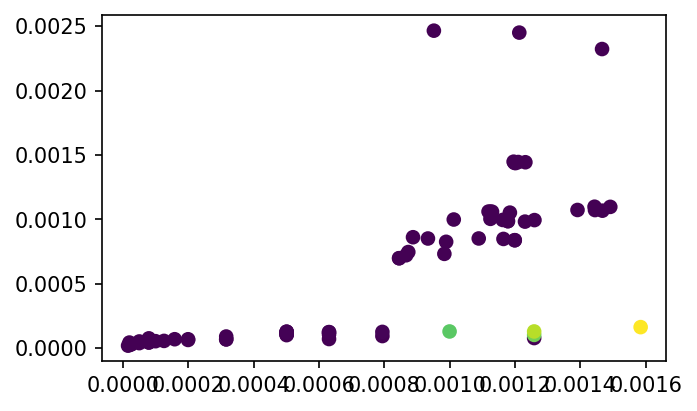

In [352]:
plt.scatter(DLi, dpmid, c=Kfx2)

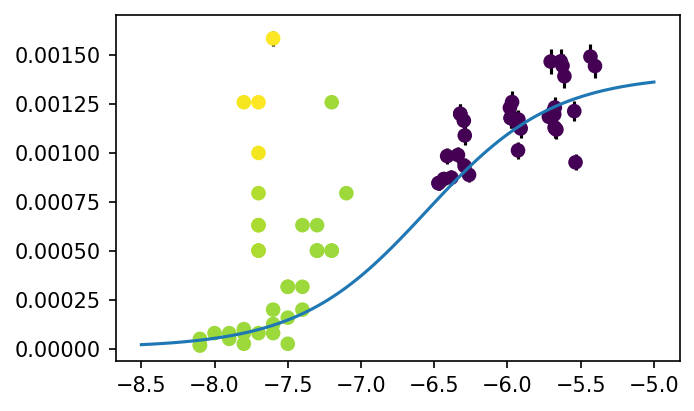

In [172]:
plt.errorbar(np.log10(Rp), DLi, yerr=DLi_err, fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp), DLi, c=Kfx1)

plt.plot(np.log10(nRp), SKM(nRp, 0.0014, 5e-6, 1e-9))

# plt.plot(np.log10(nRp), SKM(nRp, 0.003, 5e-6, 1e-9))